In [4]:
import numpy as np
import xarray as xr
import itertools
import matplotlib.pyplot as plt
from cartopy import geodesic
import cartopy.crs as ccrs
import shapely
import pandas as pd
from tqdm import tqdm
from datetime import datetime
import analysis_functions as funk
import cartopy.feature as cfeature
from cycler import cycler

from scipy.stats import kde

In [5]:
initial_depth = -5100  # int(sys.argv[1])  # 5 # 60 # 5179
lon_sample = 6.287  # 6.25
lat_sample = -32.171  # -32.171
origin = (lon_sample, lat_sample)

start_time = datetime.strptime('2019-01-20 12:00:00', '%Y-%m-%d %H:%M:%S')
sim_time = 4484
# create the date range in reverse from sampling time to the past
datelist = pd.date_range(end=start_time, periods=sim_time)[::-1]
end_time = datelist[0]

# simulations = [10] + [i for i in range(100, 501, 100)]
simulations = [500, 1000, 10000, 23000]

In [6]:
surface_events = np.load('../data/surface_events.npy', allow_pickle=True).item()
surface_events

{500: {'particle_index': array([   0,    1,    2, ..., 8189, 8190, 8191]),
  'surface_time': array([1766, 1364, 3028, ..., 1248, 1336,  767]),
  'radius': array([2.70144297e-05, 3.17771313e-05, 9.54072839e-05, ...,
         1.17324191e-04, 4.54980597e-05, 1.44773562e-04]),
  'depths': array([3.35872992, 8.30761344, 0.712733  , ..., 9.        , 0.42902467,
         9.        ]),
  'displacement': array([1166947.83957413,  248955.78880167,  596581.67783603, ...,
          834026.26358606, 1244816.4021016 ,  512608.05231838]),
  'lat': array([-37.37389978, -33.36070869, -30.75592446, ..., -38.31911217,
         -42.98104101, -29.17121135]),
  'lon': array([-4.82352057,  4.03132375, 12.35536126, ...,  1.01927253,
          9.97436607, 10.35797926])},
 1000: {'particle_index': array([   0,    1,    2, ..., 8189, 8190, 8191]),
  'surface_time': array([ 991, 1217, 1227, ..., 2477, 2174, 4149]),
  'radius': array([2.70144297e-05, 6.35542625e-05, 1.19259105e-05, ...,
         2.93310478e-05, 9.

In [7]:
ds = pd.read_csv('../data/size_distribution_surface.csv', index_col=0)
ds


,Particles,L median,L min,L max,T_s mean,T_s std,T_s median,T_s min,T_s max,X mean,X std,X median,X min,X max
500,8147.0,0.000047,6.115629e-06,0.000776,1453.326992,799.472996,1313.0,78.0,4457.0,6.987643e+05,4.262796e+05,626028.517133,8605.214888,4.954876e+06
1000,7071.0,0.000029,4.029321e-06,0.000776,2242.801018,1050.420057,2153.0,38.0,4479.0,8.612579e+05,6.091759e+05,746409.856506,16822.297303,7.719273e+06
10000,360.0,0.000020,1.015072e-07,0.000186,3159.341667,921.825455,3324.5,219.0,4478.0,1.142504e+06,9.247581e+05,918611.248056,55016.485120,6.496020e+06
23000,63.0,0.000018,3.511379e-06,0.000071,2981.269841,950.264595,3071.0,691.0,4343.0,1.284405e+06,1.219866e+06,865829.168927,128196.336737,6.718837e+06


In [46]:
mask = xr.open_dataset('/storage/shared/oceanparcels/input_data/MOi/domain_ORCA0083-N006/PSY4V3R1_mask.nc')
indices = {'lat': range(500, 1600), 'lon': range(2000, 4300)}
landmask = mask['tmask'][0, 0, indices['lat'], indices['lon']]
xlon = mask['nav_lon'][indices['lat'], indices['lon']].values
ylat = mask['nav_lat'][indices['lat'], indices['lon']].values

# mask the cell of the land == 0 

landmask = landmask.values
landmask = landmask.astype(float)
landmask = landmask[::10, ::10]
landmask[landmask == 0] = np.nan
ocean = np.isnan(landmask)
xlon = xlon[::10, ::10]
ylat = ylat[::10, ::10]


In [53]:
XY.shape

(2, 4196)

In [55]:
zi.shape

(4196,)

/tmp/ipykernel_144895/3461888845.py:14: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  k = kde.gaussian_kde([x, y])


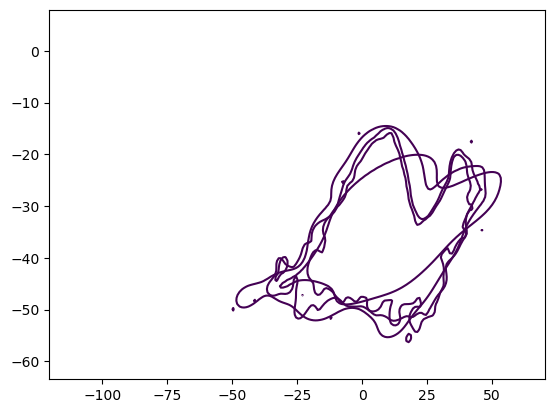

In [130]:
all_contours = {}

xi, yi = xlon, ylat
XY = np.vstack([xi.flatten(), yi.flatten()])

ocean = ocean.flatten()
# XY = XY[:, ocean]

for j, ft in enumerate(simulations[::-1]):
    x = surface_events[ft]['lon']
    y = surface_events[ft]['lat']

    # Perform a kernel density estimate on the data
    k = kde.gaussian_kde([x, y])
    zi = k(XY)
    zi_masked = np.where(ocean, zi, np.nan)

    # Find density level that includes 90% of the particles
    zi_sorted = np.sort(zi_masked.flatten())
    cumulative_zi = np.cumsum(zi_sorted)
    cumulative_zi = cumulative_zi[~np.isnan(zi_sorted)]
    level = zi_sorted[np.where(cumulative_zi >= cumulative_zi[-1] * 0.1)[0][0]]

    # Plot contours at this density level
    contours = plt.contour(xi, yi, zi.reshape(xi.shape), levels=[level])
    
    # Get the contour lines
    largest_contour_line = None
    max_length = 0
    contour_lines = []
    for collection in contours.collections:
        for path in collection.get_paths():
            if len(path.vertices) > max_length:
                max_length = len(path.vertices)
                largest_contour_line = path.vertices
    all_contours[ft] = largest_contour_line 
    

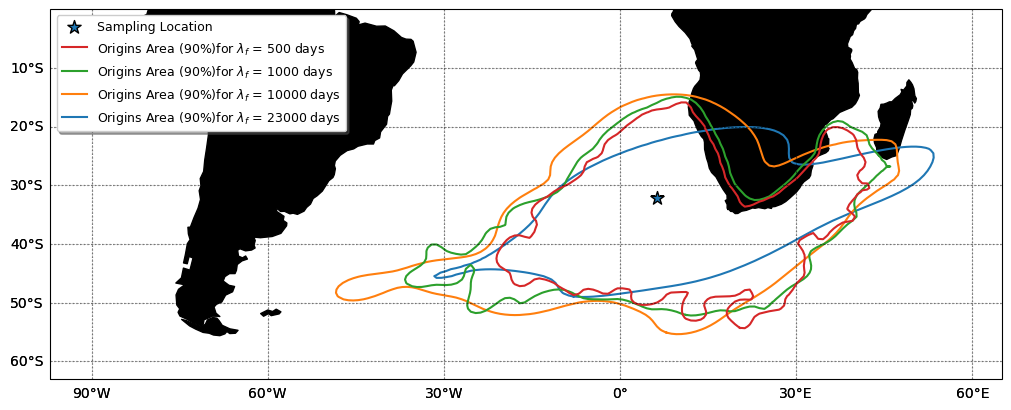

In [138]:
marker = itertools.cycle(('v', 'h', 'd', 'o', 'X', 'P', '^', 's'))

fig,ax = plt.subplots(figsize=(10,8),
                      subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.3, linestyle=':')
gl.top_labels = False
gl.right_labels = False
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='black', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# ax.set_extent([0, 40,-60.916664, -20], crs=ccrs.PlateCarree())

# ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND, zorder=1, color='black')
# ax.add_feature(cfeature.COASTLINE)

# for j, ft in enumerate(simulations[::-1]):    
#     ax.scatter(surface_events[ft]['lon'], surface_events[ft]['lat'],
#                zorder=2, s=2,
#                label=f"$\lambda_f$ = {ft} days", marker=next(marker))

for j, ft in enumerate(simulations[::-1]):  
    ax.plot(all_contours[ft][:, 0], all_contours[ft][:, 1], label=f"Origins Area (90%)for $\lambda_f$ = {ft} days ")

ax.scatter(origin[0], origin[1], zorder=5,
           label='Sampling Location', marker='*', s=100, edgecolors='black')

# for r in range(1, 10):
#     circle_points = geodesic.Geodesic().circle(lon=origin[0], lat=origin[1],
#                                                radius=r*1e6,
#                                                n_samples=360,
#                                                endpoint=False)
#     geom = shapely.geometry.Polygon(circle_points)
#     ax.add_geometries((geom,), crs=ccrs.PlateCarree(), facecolor='none',
#                       edgecolor='black', linewidth=1., zorder=3, ls='--',
#                       label=f'{r} km')
# ax.text(3.3, -24.5, r"$1,000$ km", fontsize=5)
# ax.text(-14.5, -30.5, r"$2,000$ km", fontsize=5, rotation=70)
# ax.text(-25., -30.5, r"$3,000$ km", fontsize=5, rotation=70)
# ax.text(-35.6, -30.5, r"$4,000$ km", fontsize=5, rotation=70)
# ax.text(-46.6, -31.5, r"$5,000$ km", fontsize=5, rotation=70)
# ax.text(-63.5, -48.5, r"$6,000$ km", fontsize=5, rotation=75)
# ax.text(-79.3, -52.5, r"$7,000$ km", fontsize=5, rotation=62)
# ax.text(-89.5, -45.3, r"$8,000$ km", fontsize=5, rotation=53)
# ax.text(-89.5, -27.3, r"$9,000$ km", fontsize=5, rotation=55)

handles, labels = ax.get_legend_handles_labels()
handles = handles[::-1]
labels = labels[::-1]


ax.set_extent([-97, 65, -63, 0], crs=ccrs.PlateCarree())

ax.legend(handles, labels, ncols=1, fontsize=9, shadow=True, loc='upper left') 
fig.savefig('../article_figs/Figure3_candidate.png', dpi=300,
            facecolor=(1, 0, 0, 0))

In [69]:
# drop the nans from cumulative_zi
cumulative_zi = cumulative_zi[~np.isnan(zi_sorted)]

In [70]:
zi_sorted[np.where(cumulative_zi >= cumulative_zi[-1] * 0.05)]

array([6.46273912e-06, 6.50398082e-06, 6.51068650e-06, 6.85152943e-06,
       7.00320415e-06, 7.02716020e-06, 7.18615049e-06, 7.28713963e-06,
       7.36420251e-06, 7.65300938e-06, 7.88499246e-06, 8.49229203e-06,
       8.69721756e-06, 9.27811411e-06, 9.29974464e-06, 9.44070219e-06,
       9.57680099e-06, 1.00831858e-05, 1.04160171e-05, 1.06157476e-05,
       1.07372928e-05, 1.08391075e-05, 1.09416472e-05, 1.09853129e-05,
       1.11900461e-05, 1.17270855e-05, 1.20486064e-05, 1.26970278e-05,
       1.29387493e-05, 1.29484834e-05, 1.30760171e-05, 1.33689744e-05,
       1.33793295e-05, 1.41488143e-05, 1.46385823e-05, 1.51739547e-05,
       1.52652819e-05, 1.59468025e-05, 1.63601497e-05, 1.67510432e-05,
       1.77828980e-05, 1.85557157e-05, 1.90864129e-05, 1.91763827e-05,
       2.00888910e-05, 2.10400317e-05, 2.11011550e-05, 2.12010015e-05,
       2.15580350e-05, 2.22634850e-05, 2.22694605e-05, 2.24506067e-05,
       2.27606910e-05, 2.42837928e-05, 2.44435633e-05, 2.46945799e-05,
      

In [45]:
ocean=ocean.ravel()
zi[ocean]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 10000 but corresponding boolean dimension is 25300

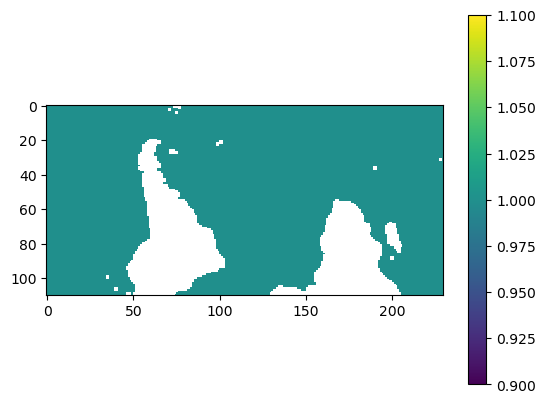

In [30]:
plt.imshow(landmask)
plt.colorbar()

In [10]:
from scipy.interpolate import griddata

In [31]:
xlon[landmask]

IndexError: arrays used as indices must be of integer (or boolean) type

In [34]:
xy = np.column_stack([ylat.ravel(), xlon.ravel()])
ocean=ocean.ravel()
xy = xy[ocean]

In [36]:
xy.shape

(4196, 2)

In [38]:
k(xy)

ValueError: points have dimension 4196, dataset has dimension 2

In [42]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

ModuleNotFoundError: No module named 'sklearn'

In [41]:


xy = np.column_stack([ylat.ravel(), xlon.ravel()])
ocean=ocean.ravel()
xy = xy[ocean]

for j, ft in enumerate(simulations):
    x = surface_events[ft]['lon']
    y = surface_events[ft]['lat']
    lon_lat = np.vstack([y, x]).T

    #initialize a KDE object & fit it to the lon/lat values from the trajectories
    kde = KernelDensity( kernel="gaussian", algorithm="ball_tree")
        
    #suggest a range of possible values of bandwidth & find best fit
    bandwidth = np.arange(0.02, 1, 0.05)
    grid = GridSearchCV(kde, {'bandwidth': bandwidth})
    
    #find KDE for the given lat/lon values
    grid.fit(lon_lat)
    kde = grid.best_estimator_

    #evaluate the KDE on the 2D grid created & get log-likelihood
    log_density = kde.score_samples(xy)
    
    #obtain probability at each grid cell
    density = np.exp(log_density)
    
     
    #normalise results
    density /= density.sum()
    
    #initialise output matrix
    z = np.zeros(x.shape)
    
    #only keep values in the ocean
    z.ravel()[ocean] = density
    z.resize(x.shape)
        
    # append the KDE values of each grid cell to the list
    kde_values.append(z)

    # Perform a kernel density estimate on the data
    k = kde.gaussian_kde(lon_lat)

    zi = k(xy)

    # Find density level that includes 90% of the particles
    zi_sorted = np.sort(zi.flatten())
    cumulative_zi = np.cumsum(zi_sorted)
    level = zi_sorted[np.where(cumulative_zi >= cumulative_zi[-1] * 0.05)[0][0]]
    
    plt.contour(xlon, ylat, zi.reshape(xlon.shape), levels=[level])


/tmp/ipykernel_144895/3691077597.py:11: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  k = kde.gaussian_kde(lon_lat)


ValueError: Number of dimensions is greater than number of samples. This results in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Note that `gaussian_kde` interprets each *column* of `dataset` to be a point; consider transposing the input to `dataset`.

In [57]:
zi_masked

array([7.84228013e-12, 1.52069692e-11, 2.90860963e-11, ...,
       2.03639350e-23, 2.08333125e-23, 2.10259448e-23])

In [41]:
# Plot contours at this density level
contours = ax.contour(xi, yi, zi.reshape(xi.shape), levels=[level])

# Get the contour lines
contour_lines = []
for collection in contours.collections:
    for path in collection.get_paths():
        contour_lines.append(path.vertices)


In [42]:
contour_lines

[array([[-79.02893468, -63.        ],
        [-79.        , -62.99703664],
        [-78.96741423, -63.        ]]),
 array([[-43.08414192, -49.        ],
        [-43.16340825, -48.36363636],
        [-43.        , -48.01745928],
        [-42.87936935, -47.72727273],
        [-42.35357771, -47.09090909],
        [-41.60377841, -46.45454545],
        [-41.36363636, -46.29681767],
        [-40.68234366, -45.81818182],
        [-39.72727273, -45.27667211],
        [-39.56489672, -45.18181818],
        [-38.2951485 , -44.54545455],
        [-38.09090909, -44.45427413],
        [-36.84926304, -43.90909091],
        [-36.45454545, -43.75051583],
        [-35.20688531, -43.27272727],
        [-34.81818182, -43.13120899],
        [-33.3558612 , -42.63636364],
        [-33.18181818, -42.57832397],
        [-31.54545455, -42.07056632],
        [-31.30196828, -42.        ],
        [-29.90909091, -41.58849721],
        [-29.10256787, -41.36363636],
        [-28.27272727, -41.12228536],
        [-

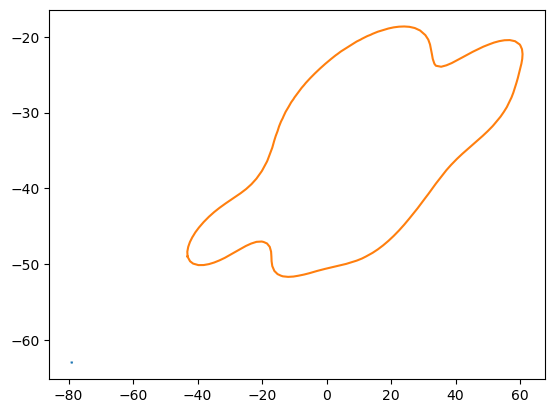

In [43]:
for line in contour_lines:
    plt.plot(line[:, 0], line[:, 1], label=f"$\lambda_f$ = {ft} days")